# TACO Trash Dataset

In [ ]:
import os
from google.colab import drive

# Verificar si ya está montado
drive_mount_point = "/content/drive"
if not os.path.ismount(drive_mount_point):
    drive.mount(drive_mount_point)
    print("🔗 Google Drive montado.")
else:
    print("✅ Google Drive ya estaba montado.")


Mounted at /content/drive
🔗 Google Drive montado.


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kneroma/tacotrashdataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tacotrashdataset


In [ ]:
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
import torchmetrics
from torchvision import transforms

In [ ]:
DATASET_PATH = os.path.join(path, 'data')
ANNOTATION_FILE = os.path.join(DATASET_PATH, 'annotations.json')
print(ANNOTATION_FILE)
assert os.path.exists(ANNOTATION_FILE), 'No se encontró annotations.json en la ruta indicada'

/kaggle/input/tacotrashdataset/data/annotations.json


In [ ]:
with open(ANNOTATION_FILE, 'r') as f:
    annotations = json.load(f)

print(annotations.keys())

dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


In [ ]:
category_map = {cat['id']: cat['name'] for cat in annotations['categories']}
annotation_df = pd.DataFrame(annotations['annotations'])
annotation_df['category_name'] = annotation_df['category_id'].map(category_map)
annotation_df.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,category_name
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0,Other carton
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap


In [ ]:
# Definir la agrupación de clases por material
custom_mapping = {
    "Cigarette": ["Cigarette"],
    "Glass Items": ["Broken glass", "Glass bottle", "Glass cup", "Glass jar"],
    "Metal Items": ["Drink can", "Pop tab", "Metal bottle cap", "Aluminium foil", "Scrap metal",
                    "Metal lid", "Aerosol", "Food Can", "Aluminium blister pack"],
    "Plastic Bottles & Caps": ["Plastic bottle cap", "Plastic bottle", "Other plastic bottle",
                               "Plastic utensils", "Tupperware", "Polypropylene bag", "Plastic straw",
                               "Plastic lid", "Plastic glooves", "Other plastic cup", "Clear plastic bottle"],
    "Plastic Wrappers & Bags": ["Plastic film", "Other plastic wrapper", "Single-use carrier bag",
                                "Other plastic container", "Garbage bag", "Plastic bag", "Other plastic bag",
                                "Crisp packet", "Other plastic"],
    "Cartons & Cardboard": ["Other carton", "Drink carton", "Meal carton", "Pizza box", "Corrugated carton"],
    "Paper & Soft Materials": ["Normal paper", "Paper cup", "Paper bag", "Magazine paper",
                               "Wrapping paper", "Egg carton", "Toilet tube", "Paper straw", "Tissues"],
    "Foam & Styrofoam": ["Styrofoam piece", "Disposable plastic cup", "Disposable food container",
                          "Foam food container", "Foam cup"],
    "Miscellaneous Waste": ["Unlabeled litter", "Rope & strings", "Food waste", "Shoe",
                            "Squeezable tube", "Battery", "Carded blister pack", "Spread tub", "Six pack rings"]
}

image_map = {image['id']: image for image in annotations['images']}

# Crear un diccionario inverso para mapeo rápido
class_to_material = {class_name: material for material, classes in custom_mapping.items() for class_name in classes}

# Copio para salvaguardar
new_annotation_df = annotation_df.copy()

# Suponiendo que 'df' es tu DataFrame con una columna 'category_name'
new_annotation_df['new_category'] = new_annotation_df['category_name'].map(class_to_material)


new_annotation_df.to_csv("new_annotations.csv", index=False)

In [ ]:
new_annotation_df

,id,image_id,category_id,segmentation,area,bbox,iscrowd,category_name,new_category
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",4.039540e+05,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Glass Items
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1.071260e+06,"[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Cartons & Cardboard
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",9.958350e+04,"[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Cartons & Cardboard
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",7.383250e+04,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle,Plastic Bottles & Caps
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",9.150000e+02,"[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap,Plastic Bottles & Caps
...,...,...,...,...,...,...,...,...,...
4779,4779,1498,16,"[[386, 1557, 635, 1567, 986, 1556, 1178, 1550,...",5.032469e+05,"[228.7143, 1550.0476, 1007.9998999999999, 578....",0,Drink carton,Cartons & Cardboard
4780,4780,1498,7,"[[1057, 1824, 1041, 1793, 1042, 1758, 1062, 17...",1.449450e+04,"[1041.3334, 1721.7142, 141.0, 138.0]",0,Plastic bottle cap,Plastic Bottles & Caps
4781,4781,1499,39,"[[1368, 1775, 1099, 1331, 862, 1494, 1099, 1944]]",1.549541e+05,"[862.0274, 1331.25, 505.97260000000006, 612.5]",0,Other plastic wrapper,Plastic Wrappers & Bags
4782,4782,1499,14,"[[1096, 1996, 1121, 2069, 1134, 2127, 1177, 22...",2.867500e+04,"[966.0, 1996.0, 211.0, 336.0]",0,Other carton,Cartons & Cardboard


In [ ]:
import albumentations as A
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# Definir transformaciones con ajuste de bounding boxes
transform = A.Compose([
    A.HorizontalFlip(p=0.5),    # Flip horizontal
    A.VerticalFlip(p=0.5),      # Flip vertical
    A.RandomResizedCrop(size=(224,224), scale=(0.8, 1.0), p=0.5),  # Cropping
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"]))

# DIR OUT
# output_dir = DATASET_PATH
output_dir = '/kaggle/working/' # [NUEVO]

# Cargar el DataFrame de anotaciones
# new_annotation_df = pd.read_csv("new_annotations.csv")  # O cargar desde otro formato

# Obtener cantidad de imágenes por clase
class_counts = new_annotation_df["new_category"].value_counts()
max_samples = class_counts.max()  # Número de imágenes en la clase mayoritaria

print(f"Clase mayoritaria: {max_samples} muestras")

# Crear una copia del DataFrame para almacenar las nuevas anotaciones
augmented_annotations = new_annotation_df.copy()
image_map_augmented = image_map.copy()

single_bbox_ids = new_annotation_df["image_id"].value_counts()
single_bbox_ids = single_bbox_ids[single_bbox_ids == 1].index
filtered_annotations = new_annotation_df[new_annotation_df["image_id"].isin(single_bbox_ids)]


# Procesar imágenes y bounding boxes
for class_name, num_samples in class_counts.items():
    # class_images = new_annotation_df[new_annotation_df["new_category"] == class_name]
    class_images = filtered_annotations[filtered_annotations["new_category"] == class_name]  # [NUEVO]


    # Calcular cuántas imágenes faltan para emparejar la clase mayoritaria
    num_missing = max_samples - num_samples

    if num_missing > 0:  # Solo augmentamos si faltan imágenes
        print(f"Augmentando {class_name}: generando {num_missing} imágenes")

        img_idx = 0
        for _ in tqdm(range(num_missing), desc=f"Augmenting {class_name}"):
            row = class_images.iloc[img_idx % len(class_images)].copy()  # Seleccionar imágenes cíclicamente
            img_path = os.path.join(DATASET_PATH, image_map[row['image_id']]['file_name'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Extraer bbox de la fila y convertir a Pascal VOC
            coco_bbox = row["bbox"]  # Formato [x_min, y_min, width, height]
            if isinstance(coco_bbox, str):
                coco_bbox = eval(coco_bbox)  # Convertir string a lista (si fue cargado desde CSV)
            xmin, ymin, width, height = coco_bbox
            xmax = xmin + width
            ymax = ymin + height
            bboxes = [[xmin, ymin, xmax, ymax]]

            try:
              # Aplicar transformaciones
              augmented = transform(image=image, bboxes=bboxes, category=[class_name])

              aug_img = augmented["image"]
              aug_bboxes = augmented["bboxes"]

              # Guardar imagen augmentada
              aug_img_name = f"aug_{_}_{image_map[row['image_id']]['file_name']}"
              aug_img_path = os.path.join(output_dir, aug_img_name)
              os.makedirs(os.path.dirname(aug_img_path), exist_ok=True)
              cv2.imwrite(aug_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

              # Agregar nueva anotación al DataFrame
              if aug_bboxes:
                  new_bbox = aug_bboxes[0]
                  xmin, ymin, xmax, ymax = new_bbox
                  coco_bbox_aug = [xmin, ymin, xmax - xmin, ymax - ymin]
                  row["bbox"] = coco_bbox_aug

                  new_image_id = f"aug_{_}_{row['image_id']}"
                  image_map_augmented[new_image_id] = {"file_name": aug_img_name}
                  row["image_id"] = new_image_id
                  row["augmented"] = True

                  # Append the modified row to the augmented dataframe
                  augmented_annotations = pd.concat([augmented_annotations, pd.DataFrame([row])], ignore_index=True)

              img_idx += 1  # Avanzar al siguiente archivo original

            except ValueError:
              # Si hay un ValueError (bbox fuera de rango), omitir esta aumentación
              print(f"Omitiendo aumentación para imagen {image_map[row['image_id']]['file_name']} debido a bbox fuera de rango")
              continue  # Pasar a la siguiente iteración del bucle


# Guardar DataFrame actualizado
augmented_annotations.to_csv("augmented_annotations.csv", index=False)
print("Dataset balanceado con éxito")


Clase mayoritaria: 1121 muestras
Augmentando Plastic Bottles & Caps: generando 293 imágenes


Augmenting Plastic Bottles & Caps: 100%|██████████| 293/293 [00:38<00:00,  7.64it/s]


Augmentando Cigarette: generando 454 imágenes


Augmenting Cigarette: 100%|██████████| 454/454 [01:07<00:00,  6.75it/s]


Augmentando Miscellaneous Waste: generando 536 imágenes


Augmenting Miscellaneous Waste: 100%|██████████| 536/536 [01:18<00:00,  6.79it/s]


Augmentando Metal Items: generando 571 imágenes


Augmenting Metal Items: 100%|██████████| 571/571 [01:09<00:00,  8.27it/s]


Augmentando Foam & Styrofoam: generando 839 imágenes


Augmenting Foam & Styrofoam: 100%|██████████| 839/839 [01:43<00:00,  8.09it/s]


Augmentando Paper & Soft Materials: generando 859 imágenes


Augmenting Paper & Soft Materials: 100%|██████████| 859/859 [01:48<00:00,  7.91it/s]


Augmentando Glass Items: generando 867 imágenes


Augmenting Glass Items: 100%|██████████| 867/867 [01:45<00:00,  8.24it/s]


Augmentando Cartons & Cardboard: generando 886 imágenes


Augmenting Cartons & Cardboard: 100%|██████████| 886/886 [01:35<00:00,  9.23it/s]


Dataset balanceado con éxito


In [ ]:
image_map_augmented[new_image_id]

{'file_name': 'aug_885_batch_2/000097.JPG'}

In [ ]:
augmented_annotations

,id,image_id,category_id,segmentation,area,bbox,iscrowd,category_name,new_category,augmented
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Glass Items,NaN
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Cartons & Cardboard,NaN
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Cartons & Cardboard,NaN
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle,Plastic Bottles & Caps,NaN
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap,Plastic Bottles & Caps,NaN
...,...,...,...,...,...,...,...,...,...,...
10083,2225,aug_881_695,18,"[[1163.0, 1136.0, 1236.0, 1112.0, 1270.0, 1097...",43125.0,"[1134.9999961853027, 1870.9999523162842, 253.0...",0,Meal carton,Cartons & Cardboard,True
10084,2227,aug_882_697,14,"[[1239.0, 1888.0, 1291.0, 1917.0, 1296.0, 1923...",98012.0,"[1239.0000629425049, 1220.0000610351562, 478.9...",0,Other carton,Cartons & Cardboard,True
10085,2331,aug_883_746,14,"[[1148.0, 1321.0, 1276.0, 1275.0, 1324.0, 1258...",199257.0,"[73.91176509857178, 101.11111259460449, 47.970...",0,Other carton,Cartons & Cardboard,True
10086,2359,aug_884_759,14,"[[1427.0, 1569.0, 1400.0, 1626.0, 1393.0, 1656...",48364.0,"[1020.9999847412109, 1527.0000457763672, 311.9...",0,Other carton,Cartons & Cardboard,True


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Filtrar solo las imágenes augmentadas
augmented_only = augmented_annotations[augmented_annotations["augmented"] == True]

# Tomar una muestra por clase
sampled = augmented_only.groupby("new_category").first().reset_index()

# Función para mostrar una imagen con bounding box
def show_image_with_bbox(img_path, bbox, label):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title(f"Clase: {label}")
    plt.axis('off')
    plt.show()

# Mostrar una imagen augmentada por cada clase
for _, row in sampled.iterrows():
    image_id = row["image_id"]
    img_info = image_map_augmented.get(image_id)

    if img_info is not None:
        img_path = os.path.join(output_dir, img_info["file_name"])
        bbox = row["bbox"]
        if isinstance(bbox, str):
            bbox = eval(bbox)  # Por si fue guardado como string en CSV

        show_image_with_bbox(img_path, bbox, row["new_category"])

Output hidden; open in https://colab.research.google.com to view.

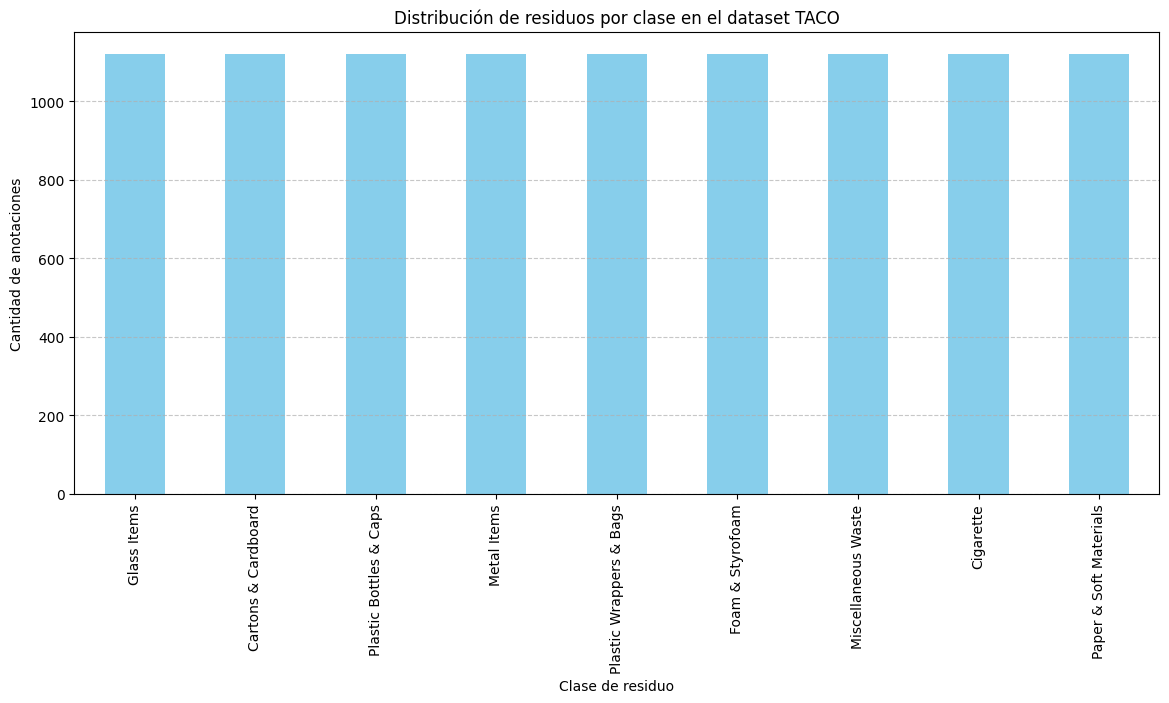

In [ ]:
plt.figure(figsize=(14, 6))
augmented_annotations['new_category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de residuos por clase en el dataset TACO')
plt.xlabel('Clase de residuo')
plt.ylabel('Cantidad de anotaciones')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
!zip -r /kaggle/augmented.zip /kaggle/working

Se han truncado las últimas 5000 líneas del flujo de salida.
  adding: kaggle/working/aug_66_batch_14/000038.jpg (deflated 5%)
  adding: kaggle/working/aug_794_batch_5/ (stored 0%)
  adding: kaggle/working/aug_794_batch_5/000014.JPG (deflated 5%)
  adding: kaggle/working/aug_564_batch_12/ (stored 0%)
  adding: kaggle/working/aug_564_batch_12/000018.jpg (deflated 1%)
  adding: kaggle/working/aug_294_batch_4/ (stored 0%)
  adding: kaggle/working/aug_294_batch_4/000064.JPG (deflated 1%)
  adding: kaggle/working/aug_315_batch_14/ (stored 0%)
  adding: kaggle/working/aug_315_batch_14/000011.jpg (deflated 1%)
  adding: kaggle/working/aug_745_batch_7/ (stored 0%)
  adding: kaggle/working/aug_745_batch_7/000142.JPG (deflated 6%)
  adding: kaggle/working/aug_745_batch_7/000042.JPG (deflated 5%)
  adding: kaggle/working/aug_41_batch_15/ (stored 0%)
  adding: kaggle/working/aug_41_batch_15/000068.jpg (deflated 1%)
  adding: kaggle/working/aug_601_batch_1/ (stored 0%)
  adding: kaggle/working/aug_

In [ ]:
import json

# Ruta donde se va a guardar
with open("image_map_augmented.json", "w") as f:
    json.dump(image_map_augmented, f)

In [ ]:
%%script echo skipping


import shutil
import os

def borrar_carpetas_aug(ruta_base):
  """Borra carpetas que empiecen con 'aug' y su contenido."""
  for nombre_archivo in os.listdir(ruta_base):
    ruta_completa = os.path.join(ruta_base, nombre_archivo)
    if os.path.isdir(ruta_completa) and nombre_archivo.startswith('aug'):
      print(f"Borrando: {ruta_completa}")
      shutil.rmtree(ruta_completa)

# Reemplaza con la ruta real de tu dataset
ruta_dataset = '/root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data'

borrar_carpetas_aug(ruta_dataset)
print("Carpetas 'aug' borradas con éxito.")

# Parche

In [ ]:
import pandas as pd

# Cargar CSV
df = pd.read_csv("/content/drive/MyDrive/VC2/augmented_annotations.csv")

# Codificar nuevas categorías a partir de 'new_category'
category_mapping = {cat: idx for idx, cat in enumerate(df["new_category"].unique(), start=1)}
df["category_id"] = df["new_category"].map(category_mapping)

# Reemplazar NaN o cadenas vacías en 'augmented' por False
df["augmented"] = df["augmented"].fillna(False).replace('', False)

# Verificar resultado
print("Mapeo de categorías aplicado:")
print(category_mapping)
df.head()


<ipython-input-2-e4e2e357c183>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["augmented"] = df["augmented"].fillna(False).replace('', False)


Mapeo de categorías aplicado:
{'Glass Items': 0, 'Cartons & Cardboard': 1, 'Plastic Bottles & Caps': 2, 'Metal Items': 3, 'Plastic Wrappers & Bags': 4, 'Foam & Styrofoam': 5, 'Paper & Soft Materials': 6, 'Miscellaneous Waste': 7, 'Cigarette': 8}


,id,image_id,category_id,segmentation,area,bbox,iscrowd,category_name,new_category,augmented
0,1,0,0,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Glass Items,False
1,2,1,1,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Cartons & Cardboard,False
2,3,1,1,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Cartons & Cardboard,False
3,4,2,2,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle,Plastic Bottles & Caps,False
4,5,2,2,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap,Plastic Bottles & Caps,False


In [ ]:
df.sample(20)

,id,image_id,category_id,segmentation,area,bbox,iscrowd,category_name,new_category,augmented
9664,2227,aug_462_697,1,"[[1239.0, 1888.0, 1291.0, 1917.0, 1296.0, 1923...",9.801200e+04,"[730.0000476837158, 1706.0000381469727, 478.99...",0,Other carton,Cartons & Cardboard,True
3696,3697,1199,6,"[[865.0, 1304.0, 416.0, 2000.0, 373.0, 2118.0,...",1.214750e+06,"[373.0, 1047.0, 1439.0, 1389.0]",0,Paper cup,Paper & Soft Materials,False
98,99,38,4,"[[1358.0, 1469.0, 1353.0, 1447.0, 1346.0, 1421...",4.336450e+04,"[1346.0, 1367.0, 191.0, 292.0]",0,Plastic film,Plastic Wrappers & Bags,False
9499,4434,aug_297_1378,1,"[[679, 2183, 716, 2333, 724, 2412, 919, 2390, ...",5.363850e+04,"[132.83951568603516, 120.00000508626302, 24.09...",0,Other carton,Cartons & Cardboard,True
1411,1411,394,7,"[[2903, 1906, 2941, 1869, 3006, 1824, 3022, 18...",8.629300e+04,"[2903.0, 1815.0, 465.0, 332.0]",0,Unlabeled litter,Miscellaneous Waste,False
1333,1333,382,4,"[[1294, 1417, 1254, 923, 1320, 921, 2019, 1018...",3.019201e+06,"[60.0, 907.0, 3109.0, 1767.0]",0,Other plastic wrapper,Plastic Wrappers & Bags,False
5803,745,aug_272_221,7,"[[2489, 1723, 2551, 1673, 2618, 1629, 2706, 15...",2.101665e+05,"[84.97131096728855, 88.9224624633789, 52.37727...",0,Rope & strings,Miscellaneous Waste,True
838,838,272,4,"[[598, 1862, 615, 1921, 663, 1920, 682, 1922, ...",2.830500e+03,"[596.0, 1836.0, 86.0, 86.0]",0,Plastic film,Plastic Wrappers & Bags,False
6347,2502,aug_280_786,3,"[[1129.0, 1582.0, 1131.0, 1589.0, 1136.0, 1590...",4.032500e+04,"[107.26079590291762, 110.65536421436374, 31.72...",0,Drink can,Metal Items,True
1546,1546,428,3,"[[1102, 2840, 1324, 2796, 2196, 2605, 2337, 25...",2.096998e+06,"[398.0, 1433.0, 2082.0, 1407.0]",0,Drink can,Metal Items,False


In [ ]:
df.to_csv("/content/drive/MyDrive/VC2/augmented_annotations_fixed.csv", index=False)